In [1]:
import numpy as np
import networkx as nx
from default_architecture_class import default_arhitecture
from default_architecture_class import arhitecture_specs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from gates import AndGate, OrGate, XorGate, NandGate, BitPhaseEncoder
from Multiplier import Multiplier2x2

In [3]:
lambdas = np.array([3, 5, 7, 11, 13])
spec = arhitecture_specs(M=5, m0=1, S=3, lambdas=lambdas, x_values=np.array([0.0, 1.0, 2.0]))

In [5]:
theta = encode_bit_to_phases(1, lambdas = np.array([3, 5, 7, 11, 13]))

NameError: name 'encode_bit_to_phases' is not defined

In [7]:
theta

NameError: name 'theta' is not defined

In [9]:
np.shape(np.vstack(theta).T)

NameError: name 'theta' is not defined

In [11]:
arch = default_arhitecture(spec)

In [13]:
arch.forward(np.vstack(theta).T)

NameError: name 'theta' is not defined

In [15]:
#lambdas = np.array([3,5,7])
#x_values = np.array([0,1,2])

#spec = arhitecture_specs(M=3, m0=2, S=3, lambdas=lambdas, x_values=x_values, M = )
#arch = default_arhitecture(spec)


def draw_architecture(G, figsize=(14, 6), label_shift=0.25):
    cmap = cm.get_cmap("tab10")
    stages = {}
    for n, data in G.nodes(data=True):
        stage = data.get("stage")
        stages.setdefault(stage, []).append(n)
    stage_order = ["input_code", "logical_weights", "trig", "decoder", "encoder", "output_code", "unknown"]
    stage_order = [s for s in stage_order if s in stages]

    pos = {}
    for x, s in enumerate(stage_order):
        nodes = sorted(stages[s])
        for idx, n in enumerate(nodes):
            pos[n] = (x, -idx)
    
    stage_to_color = {s: i for i, s in enumerate(stage_order)}
    node_colors = [stage_to_color[G.nodes[n].get("stage")] for n in G.nodes()]

    plt.figure(figsize=figsize)

    # edges (with arrows)
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=12,
        width=1.0,
        alpha=0.35,
        connectionstyle="arc3,rad=0.0"
    )

    # nodes
    nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap=cmap,
    vmin=0,
    vmax=max(stage_to_color.values()) if stage_to_color else 1,
    node_size=350,
    linewidths=0.8
)

    labels = {n: n for n in G.nodes()}
    label_pos = {n: (pos[n][0], pos[n][1] - label_shift) for n in G.nodes()}
    nx.draw_networkx_labels(G, label_pos, labels=labels, font_size=7)

    edge_labels = {
            (u, v): data["weight"]
            for u, v, data in G.edges(data=True)
            if data.get("weight") is not None
        }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    cmap = cm.get_cmap("tab10")

    plt.axis("off")
    plt.tight_layout()
    plt.show()


C:\Users\yusuf\AppData\Local\Temp\ipykernel_7644\2038560003.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")
C:\Users\yusuf\AppData\Local\Temp\ipykernel_7644\2038560003.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


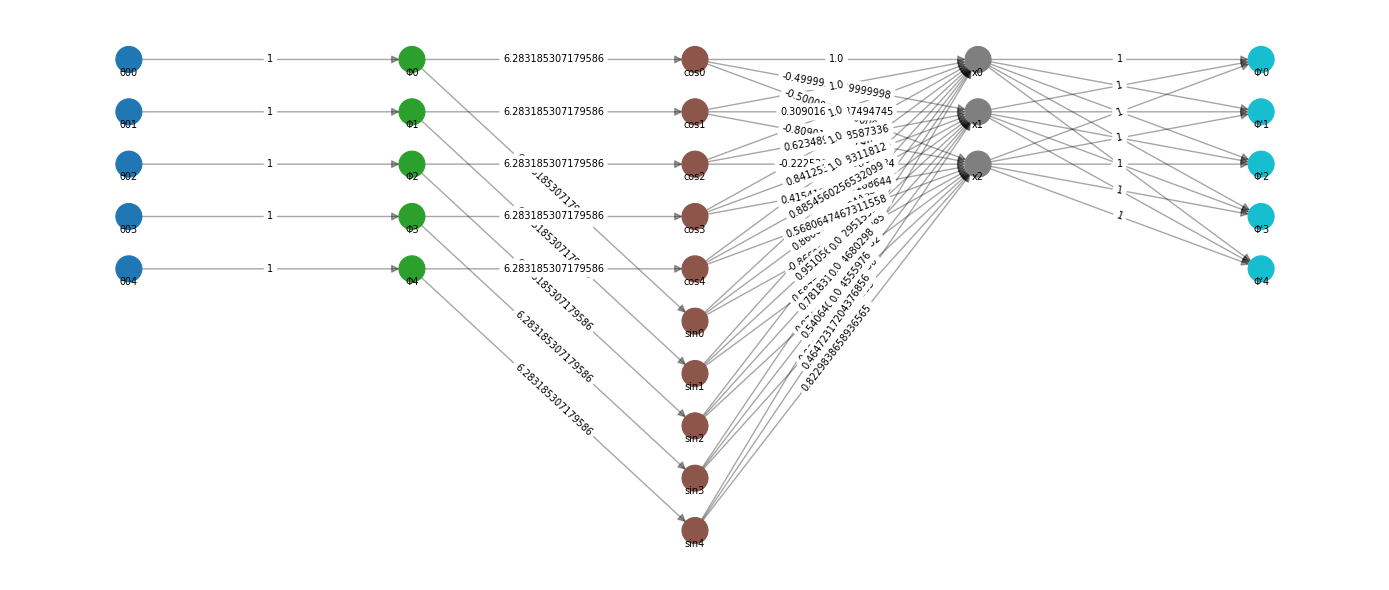

In [17]:
G = arch.graph()   # or whatever you called it
draw_architecture(G)

In [19]:
def decode_phases(out_phases, x_values, lambdas):
    out_phases = np.asarray(out_phases, dtype=float)
    x_values = np.asarray(x_values, dtype=float)
    lambdas = np.asarray(lambdas, dtype=float)

    scores = []
    for xk in x_values:
        acc = 0.0
        for j in range(len(lambdas)):
            acc += np.cos(2*np.pi*(out_phases[j] - xk/lambdas[j]))
        scores.append(acc)

    k_hat = int(np.argmax(scores))
    return x_values[k_hat], np.array(scores)


### Gate testing

In [22]:
lambdas = np.array([3, 5, 7])
x_values = np.array([0.0, 1.0, 2.0])
spec = arhitecture_specs(M=3, m0=2, S=3, lambdas=lambdas, x_values=x_values)
gate = NandGate(spec, sigma_phase=0.0, sigma_trig=0.0, sigma_score=0.0, p=0.0, logical_weights=[1, 1])
def encode_y_to_phases(y: float, lambdas: np.ndarray) -> np.ndarray:
        return (y / lambdas) % 1.0

# Inputs: (1,1) -> sum=2 -> AND=1
theta = np.vstack([
    encode_y_to_phases(0.0, spec.lambdas),
    encode_y_to_phases(0.0, spec.lambdas),
])
out = gate.forward(theta)

print("decoded k_hat:", out["k_hat"], "decoded x_k:", spec.x_values[out["k_hat"]])
print("out_phases:", out["out_phases"])

y_hat = decode_phases(
        out["out_phases"],
        spec.x_values,
        spec.lambdas
)
print(y_hat[0])

decoded k_hat: 0 decoded x_k: 0.0
out_phases: [0.33333333 0.2        0.14285714]
1.0


### Multiplier testing

In [24]:
spec = arhitecture_specs(
    M=5,
    m0=2,
    S=3,
    lambdas=np.array([3, 5, 7, 11, 13], dtype=float),
    x_values=np.array([0.0, 1.0, 2.0], dtype=float),
)

# --- 2) Build multiplier
mult = Multiplier2x2(spec)

# --- 3) Input numbers (2-bit each)
A = 3   # binary 10
B = 1   # binary 11

# split into bits
a1, a0 = (A >> 1) & 1, A & 1
b1, b0 = (B >> 1) & 1, B & 1

# --- 4) Run multiplier
out = mult.forward_bits(a1, a0, b1, b0)

# --- 5) Decode output bits (simple nearest check)
def decode_bit(phases, lambdas):
    lambdas = np.asarray(lambdas, float)
    proto0 = np.zeros_like(lambdas)
    proto1 = (1.0 / lambdas) % 1.0
    d0 = np.sum(np.abs(phases - proto0))
    d1 = np.sum(np.abs(phases - proto1))
    return 0 if d0 < d1 else 1

p0 = decode_bit(out["p0"], spec.lambdas)
p1 = decode_bit(out["p1"], spec.lambdas)
p2 = decode_bit(out["p2"], spec.lambdas)
p3 = decode_bit(out["p3"], spec.lambdas)

# --- 6) Result
product = (p3 << 3) | (p2 << 2) | (p1 << 1) | p0

print(f"A = {A} ({a1}{a0})")
print(f"B = {B} ({b1}{b0})")
print(f"Result bits = {p3}{p2}{p1}{p0}")
print(f"Result = {product}")

A = 3 (11)
B = 1 (01)
Result bits = 0011
Result = 3


In [26]:
lambdas = [3, 5, 7, 11, 13]
encNN = BitPhaseEncoder(M=len(lambdas), lambdas=lambdas)

ph0 = encNN.forward_bit(0)
ph1 = encNN.forward_bit(1)

print("bit 0 phases:", ph0)
print("bit 1 phases:", ph1)

bit 0 phases: [0. 0. 0. 0. 0.]
bit 1 phases: [0.33333333 0.2        0.14285714 0.09090909 0.07692308]


In [28]:
enc = BitPhaseEncoder(M=5, lambdas=[3,5,7,11,13])
print("Encoder weights (x_k → Φ'_j):")
for u, v, d in enc.G.edges(data=True):
    if u.startswith("x") and v.startswith("Φ'"):
        print(f"{u} -> {v} : {d['weight']}")


Encoder weights (x_k → Φ'_j):
x0 -> Φ'0 : 0.0
x0 -> Φ'1 : 0.0
x0 -> Φ'2 : 0.0
x0 -> Φ'3 : 0.0
x0 -> Φ'4 : 0.0
x1 -> Φ'0 : 0.3333333333333333
x1 -> Φ'1 : 0.2
x1 -> Φ'2 : 0.14285714285714285
x1 -> Φ'3 : 0.09090909090909091
x1 -> Φ'4 : 0.07692307692307693


In [30]:
x_values = np.array([0.0,1.0,2.0])

In [32]:
gate_spec = arhitecture_specs(
    M=5, m0=2, S=3,
    lambdas=np.array([3,5,7,11,13], float),
    x_values=np.array([0.0,1.0,2.0], float),
)

mult = Multiplier2x2(gate_spec)

# A=2 (10), B=3 (11)
out = mult.forward_bits(a1=1, a0=0, b1=1, b0=1)
print(out["p3"], out["p2"], out["p1"], out["p0"])

[0. 0. 0. 0. 0.] [0.33333333 0.2        0.14285714 0.09090909 0.07692308] [0.33333333 0.2        0.14285714 0.09090909 0.07692308] [0. 0. 0. 0. 0.]


In [34]:
out["p3"]

array([0., 0., 0., 0., 0.])

In [36]:
decode_phases(out["p3"], x_values=x_values, lambdas=np.array([3, 5, 7, 11, 13]))

(0.0, array([ 5.        ,  2.15921635, -0.54805817]))

In [38]:
print(decode_bit(out["p3"], lambdas=np.array([3,5,7,11,13], float)), decode_bit(out["p2"], lambdas=np.array([3,5,7,11,13], float)), decode_bit(out["p1"], lambdas=np.array([3,5,7,11,13], float)), decode_bit(out["p0"], lambdas=np.array([3,5,7,11,13], float)))

0 1 1 0


# PLOT

In [44]:
import numpy as np
import matplotlib.pyplot as plt

from gates import AndGate
from gates import BitPhaseEncoder
from default_architecture_class import arhitecture_specs


In [46]:
M = 7
lambdas = np.array([3, 4, 5, 7, 11, 13, 17], dtype=float)

spec = arhitecture_specs(
    M=M,
    m0=2,              # two-input gate
    S=3,               # decoded sums: {0,1,2}
    lambdas=lambdas,
    x_values=np.array([0.0, 1.0, 2.0])
)

In [48]:
def decode_bit(out_phases, lambdas):
    scores = []
    for x in [0.0, 1.0]:
        score = 0.0
        for j in range(len(lambdas)):
            angle = 2 * np.pi * (x / lambdas[j])
            score += np.cos(2*np.pi*out_phases[j] - angle)
        scores.append(score)
    return int(np.argmax(scores))


In [50]:
def estimate_and_error(
    sigma_phase=0.0,
    sigma_trig=0.0,
    sigma_score=0.0,
    p=0.0,
    trials=2000,
):
    errors = 0

    gate = AndGate(
        spec,
        sigma_phase=sigma_phase,
        sigma_trig=sigma_trig,
        sigma_score=sigma_score,
        p=p,
    )

    enc = BitPhaseEncoder(
        M,
        lambdas,
        sigma_phase=sigma_phase,
        sigma_trig=sigma_trig,
        sigma_score=sigma_score,
        p=p,
    )

    for _ in range(trials):
        a = np.random.randint(0, 2)
        b = np.random.randint(0, 2)

        A = enc.forward_bit(a)
        B = enc.forward_bit(b)

        out = gate.forward(np.vstack([A, B]))["out_phases"]
        y_hat = decode_bit(out, lambdas)

        if y_hat != (a & b):
            errors += 1

    return errors / trials


In [52]:
sigmas = np.linspace(0.0, 0.5, 12)
error_rates = []

for s in sigmas:
    err = estimate_and_error(
        sigma_phase=s,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_rates.append(err)
    print(f"sigma_phase={s:.3f}, error={err:.4f}")


sigma_phase=0.000, error=0.0000
sigma_phase=0.045, error=0.0053
sigma_phase=0.091, error=0.1647
sigma_phase=0.136, error=0.3747
sigma_phase=0.182, error=0.4407
sigma_phase=0.227, error=0.4727
sigma_phase=0.273, error=0.4757
sigma_phase=0.318, error=0.4800
sigma_phase=0.364, error=0.4863
sigma_phase=0.409, error=0.4897
sigma_phase=0.455, error=0.4910
sigma_phase=0.500, error=0.5003


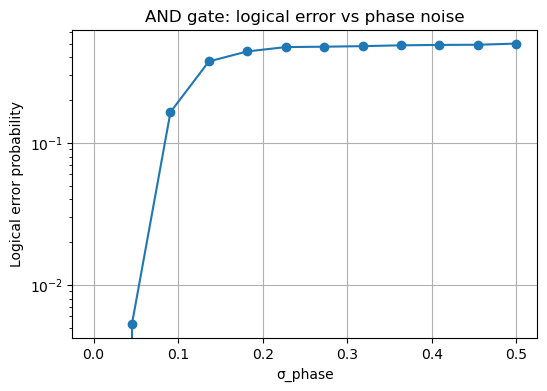

In [54]:
plt.figure(figsize=(6,4))
plt.plot(sigmas, error_rates, marker="o")
plt.xlabel("σ_phase")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs phase noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [57]:
sigma_trigs = np.linspace(0.0, 0.5, 12)
error_trig = []

for s in sigma_trigs:
    err = estimate_and_error(
        sigma_phase=0.0,
        sigma_trig=s,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_trig.append(err)
    print(f"sigma_trig={s:.3f}, error={err:.4f}")


sigma_trig=0.000, error=0.0000
sigma_trig=0.045, error=0.0000
sigma_trig=0.091, error=0.0000
sigma_trig=0.136, error=0.0000
sigma_trig=0.182, error=0.0000
sigma_trig=0.227, error=0.0000
sigma_trig=0.273, error=0.0000
sigma_trig=0.318, error=0.0000
sigma_trig=0.364, error=0.0000
sigma_trig=0.409, error=0.0007
sigma_trig=0.455, error=0.0013
sigma_trig=0.500, error=0.0040


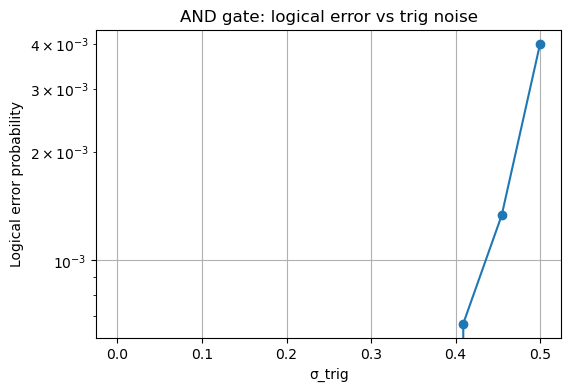

In [58]:
plt.figure(figsize=(6,4))
plt.plot(sigma_trigs, error_trig, marker="o")
plt.xlabel("σ_trig")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs trig noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [61]:
sigma_scores = np.linspace(0.0, 0.5, 12)
error_score = []

for s in sigma_scores:
    err = estimate_and_error(
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=s,
        p=0.0,
        trials=3000,
    )
    error_score.append(err)
    print(f"sigma_score={s:.3f}, error={err:.4f}")


sigma_score=0.000, error=0.0000
sigma_score=0.045, error=0.0000
sigma_score=0.091, error=0.0000
sigma_score=0.136, error=0.0000
sigma_score=0.182, error=0.0000
sigma_score=0.227, error=0.0000
sigma_score=0.273, error=0.0000
sigma_score=0.318, error=0.0000
sigma_score=0.364, error=0.0000
sigma_score=0.409, error=0.0000
sigma_score=0.455, error=0.0000
sigma_score=0.500, error=0.0000


C:\Users\yusuf\AppData\Local\Temp\ipykernel_7644\1893448764.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


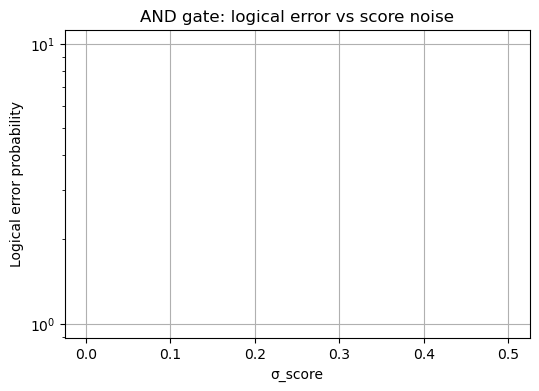

In [63]:
plt.figure(figsize=(6,4))
plt.plot(sigma_scores, error_score, marker="o")
plt.xlabel("σ_score")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs score noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [65]:
ps = np.linspace(0.0, 0.5, 11)
error_p = []

for p_val in ps:
    err = estimate_and_error(
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=p_val,
        trials=3000,
    )
    error_p.append(err)
    print(f"p={p_val:.3f}, error={err:.4f}")


p=0.000, error=0.0000
p=0.050, error=0.0267
p=0.100, error=0.0923
p=0.150, error=0.1430
p=0.200, error=0.2057
p=0.250, error=0.2303
p=0.300, error=0.2387
p=0.350, error=0.2477
p=0.400, error=0.2523
p=0.450, error=0.2717
p=0.500, error=0.2460


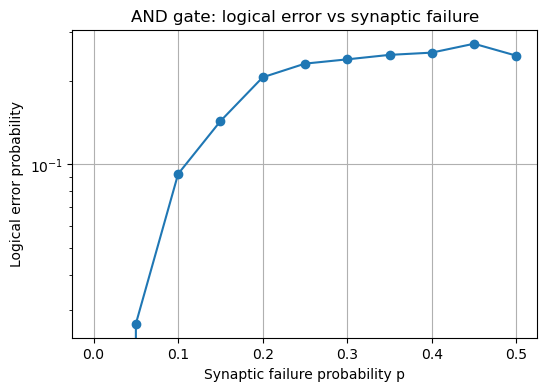

In [67]:
plt.figure(figsize=(6,4))
plt.plot(ps, error_p, marker="o")
plt.xlabel("Synaptic failure probability p")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs synaptic failure")
plt.yscale("log")
plt.grid(True)
plt.show()
